# Import

In [1]:
import cv2
import math
import os
import imageio

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score

import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Config

In [2]:
IMG_PATH = '09162021complete.tif'
CHECK_PATH = 'models/best_checkpoint.pth'
_, imgs = cv2.imreadmulti(IMG_PATH, [], cv2.IMREAD_ANYDEPTH)

In [4]:
## Config
PLOT_PATH = "intensity_plots"
DROP_BOX_SIZE = 36
DIVISION_THRESHOLD = 0.15
MISSING_FRAME_ALLOWED = 1

IMG_SIZE = 600
ENTIRE_WIDTH = 3640
ENTIRE_HEIGHT = 2730
DIVISION_THRESHOLD = 0.25
TRACKING_THRESHOLD = 0.5
NORMALIZE = False 
DEVICE = torch.device('cpu')
BOX_DETECTIONS_PER_IMG = 539

RESNET_MEAN = (0.0163, 0.0163, 0.0163)
RESNET_STD = (0.0482, 0.0482, 0.0482)
MASK_THRESHOLD = 0.25

# Load model from result

In [5]:
def get_model():
    # This is just a dummy value for the classification head
    NUM_CLASSES = 2
    
    if NORMALIZE:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, 
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG,
                                                                   image_mean=RESNET_MEAN, 
                                                                   image_std=RESNET_STD)
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                  box_detections_per_img=BOX_DETECTIONS_PER_IMG)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)
    return model


# Get the Mask R-CNN model and load the pretrained weights
model = get_model()

checkpoint = torch.load(CHECK_PATH)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [6]:
def is_at_edge(box):
    if box[0] < 50 or box[1] < 50 or box[2] > 550 or box[3] > 550: return True
    return False

def get_box_area(box):
    return abs((box[2] - box[0]) * (box[3] - box[1]))

def get_box(a_mask):
        ''' Get the bounding box of a given mask '''
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]


def get_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])

	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

def get_intensity(box, mask, img):
    x11, y11, x21, y21 = box
    x11 = math.floor(x11)
    y11 = math.floor(y11)
    x21 = math.ceil(x21)
    y21 = math.ceil(y21)
    if x21 >= IMG_SIZE: x21 = IMG_SIZE - 1
    if y21 >= IMG_SIZE: y21 = IMG_SIZE - 1
    # mask = mask[0] > MASK_THRESHOLD
    intensity = 0
    for r in range(y11, y21 + 1):
        for c in range(x11, x21 + 1):
            if mask[r][c]:
                intensity = intensity + img[r][c]

    return intensity

def box_distance(box1, box2):
    x11, y11, x21, y21 = box1
    x11_2, y11_2, x21_2, y21_2 = box2
    x_center1, y_center1 = (x11 + x21)/2, (y11 + y21)/2
    x_center2, y_center2 = (x11_2 + x21_2)/2, (y11_2 + y21_2)/2
    
    return math.sqrt((x_center1 - x_center2)**2 + (y_center1 - y_center2)**2)

def mask_iou(mask1, mask2):
    intersection = (mask1 * mask2).sum()
    if intersection == 0:
        return 0.0
    union = np.logical_or(mask1, mask2).astype(int).sum()
    return intersection / union

    


# Process All Cells in entire 600*600 frame

In [7]:
# Initialize a dictionary by the first frame
# each key represent the id of a cell
# the format for each frame is (frame_id, bbox, intensity)

def init_dict(image):
    cell_dict = {}
    initial_mask_dict = {}
    img = F.to_tensor(image)
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]
    
    masks = preds['masks'].cpu().detach().numpy()

    for idx, mask in enumerate(masks):
        
        binary_mask = mask[0] > MASK_THRESHOLD
        bbox = get_box(binary_mask)
        intensity = get_intensity(get_box(binary_mask), binary_mask, image)
        cell_dict[idx] = [(145, bbox, intensity)]
        initial_mask_dict[idx] = binary_mask

    return cell_dict, initial_mask_dict
        

def finalize_dict(cell_dict, intial_mask_dict, images):
    relationship_dict = {}
    children_dict = {}
    prev_masks_dict = intial_mask_dict

    # Iterate over all frames
    for frame_id in range(len(imgs)-2, 0, -1):
        image = images[frame_id][y:y+IMG_SIZE, x:x+IMG_SIZE]
        img = F.to_tensor(image)
        with torch.no_grad():
            preds = model([img.to(DEVICE)])[0]
        # bboxes = preds['boxes']
        # masks = preds['masks'].cpu().detach().numpy()
        masks = preds['masks'].cpu().detach().numpy()
        
        for id in cell_dict:
            prev_info = cell_dict[id][-1]
            if prev_info[0] <= frame_id + 1 + MISSING_FRAME_ALLOWED:
                bbox_prev = prev_info[1]
                mask_prev = prev_masks_dict[id]
                best_iou = 0
                best_id = 0
                best_bbox = []
                best_mask = None

                for idx, mask in enumerate(masks):
                    binary_mask = mask[0] > MASK_THRESHOLD
                    bbox = get_box(binary_mask)
                    box_iou = get_iou(bbox_prev, bbox)
                    if box_iou > 0:
                        # print(binary_mask.astype(int))
                        # print(mask_prev)
                        iou = mask_iou(binary_mask.astype(int), mask_prev.astype(int))
                        if iou > best_iou:
                            best_iou = iou
                            best_id = idx
                            best_mask = binary_mask
                            best_bbox = bbox
        
                if best_iou > 0:
                    intensity = get_intensity(best_bbox, masks[best_id][0] > MASK_THRESHOLD, image)
                    cell_dict[id].append((frame_id, best_bbox, intensity))
                    prev_masks_dict[id] = best_mask

        ## Check all the best_bbox in the last processed frame, if there's identical box,
        ## drop it and add it to relationship dict
        
        temp_dict = {}
        poped_ids = []

        for id_1 in cell_dict:
            bbox_1 = cell_dict[id_1][-1][1]
            bbox_1 = tuple(bbox_1)
            if bbox_1 not in temp_dict:
                temp_dict[bbox_1] = id_1
        
        for id_2 in cell_dict:
            bbox_2 = cell_dict[id_2][-1][1]
            bbox_2 = tuple(bbox_2)
            if bbox_2 in temp_dict and id_2 != temp_dict[bbox_2]:
                # print(str(id_2) + ": " + str(bbox_2))
                # print(str(temp_dict[bbox_2]) + ": " + str(cell_dict[temp_dict[bbox_2]][-1][1]))
                diff_1 = abs(cell_dict[temp_dict[bbox_2]][-1][2] - cell_dict[temp_dict[bbox_2]][-2][2])
                diff_2 = abs(cell_dict[id_2][-1][2] - cell_dict[id_2][-2][2])
                if diff_1 < diff_2:
                    key_id = temp_dict[bbox_2]
                    child_id = id_2
                else:
                    key_id = id_2
                    child_id = temp_dict[bbox_2]
                if key_id not in relationship_dict:
                    relationship_dict[key_id] = [child_id]
                else:
                    relationship_dict[key_id].append(child_id)
                children_dict[child_id] = cell_dict[child_id]
                poped_ids.append(child_id)

        for id in poped_ids:
            cell_dict.pop(id, None)
        
        del temp_dict

    
    return cell_dict, relationship_dict, children_dict
             

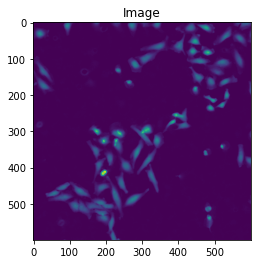

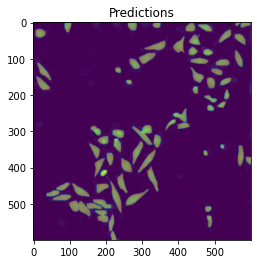

In [10]:
# Init 600*600 subimage
# @param x, y represent the lefter upper corner of 600*600 image in previous frame. 
# @param new_x and new_y represents lefter upper corner of 600*600 image in current frame.

x = 2300
y = 0
# fig, axs = plt.subplots(nrows=6, ncols=2)
# for i in range(49, 60):
img = imgs[130][y:y+IMG_SIZE, x:x+IMG_SIZE]

plt.imshow(img)
plt.title("Image")
plt.show()

img = F.to_tensor(img)
model.eval()
with torch.no_grad():
    preds = model([img.to(DEVICE)])[0]

plt.imshow(img.cpu().numpy().transpose((1,2,0)))
all_preds_masks = np.zeros((600, 600))
for mask in preds['masks'].cpu().detach().numpy():
    all_preds_masks = np.logical_or(all_preds_masks, mask[0] > MASK_THRESHOLD)
plt.imshow(all_preds_masks, alpha=0.4)
plt.title("Predictions")
plt.show()


In [11]:
cell_dict, initial_mask_dict = init_dict(imgs[145][y:y+IMG_SIZE, x:x+IMG_SIZE])
cell_dict, relationship_dict, children_dict = finalize_dict(cell_dict, initial_mask_dict, imgs)

In [12]:
# cv2.imshow("test", imgs[0][y:y+IMG_SIZE, x:x+IMG_SIZE])
print(relationship_dict)

{32: [66, 84], 76: [75], 80: [74], 81: [75, 76], 85: [74, 80], 69: [88], 89: [52], 90: [74, 80, 85], 83: [0], 57: [71, 41, 33], 59: [78], 3: [22], 46: [35, 69], 27: [21, 20], 34: [65, 49], 23: [83], 29: [81], 18: [19], 63: [60], 12: [8, 89], 50: [36], 64: [67], 61: [17], 73: [70, 54], 42: [63], 11: [24], 16: [44], 62: [11, 2], 26: [72], 39: [25], 6: [30], 53: [1], 13: [4], 28: [40], 14: [10], 5: [37]}


In [13]:
print(len(cell_dict) + len(children_dict))

91


In [29]:
def get_single_cell_info(cell_dict, id):
    infos = cell_dict[id]
    intensities = []
    for info in infos:
        intensities.insert(0, info[2])
    return range(infos[-1][0], infos[-1][0]+len(intensities)), intensities


def get_single_cell_gif(cell_dict, id):
    infos = cell_dict[id]
    gifs = []
    for info in infos:
        img = imgs[info[0]][y:y+IMG_SIZE, x:x+IMG_SIZE]
        gifs.insert(0, img[math.floor(info[1][1]):math.ceil(info[1][3]), math.floor(info[1][0]):math.ceil(info[1][2])])
    imageio.mimsave("testing.gif", gifs, fps=5)

def get_single_cell_gif_test(cell_dict, id):
    infos = cell_dict[id]
    gifs = []
    for info in infos:
        img = imgs[info[0]][y:y+IMG_SIZE, x:x+IMG_SIZE]
        img = cv2.rectangle(img, (info[1][0], info[1][1]), (info[1][2], info[1][3]), (255, 0, 0), 1)
        gifs.insert(0, img[math.floor(info[1][1])-15:math.ceil(info[1][3])+15, math.floor(info[1][0])-15:math.ceil(info[1][2])+15])
    imageio.mimsave("testing-2.gif", gifs, fps=3)


def plot_single_cell_with_children(cell_dict, relationship_dict, children_dict, id):
    if id in relationship_dict.keys():
        children = relationship_dict[id]
    else:
        children = []
    info = get_single_cell_info(cell_dict, id)
    plt.plot(info[0], info[1])
    for child in children:
        if len(children_dict[child]) > 10:
            info = get_single_cell_info(children_dict, child)
            plt.plot(info[0], info[1])
    # name = "Global-id-" + str(id) + "-" + str(math.floor(x + cell_dict[id][0][1][0])) + "-" + str(math.floor(y+cell_dict[id][0][1][1])) + ".png"
    name = "Global-id-" + str(id) + "-" + str(math.floor(cell_dict[id][0][1][0])) + "-" + str(math.floor(cell_dict[id][0][1][1])) + ".png"
    plt.savefig(PLOT_PATH + "/" + name)


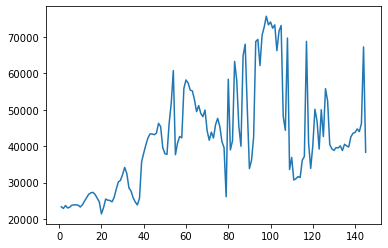

In [15]:
for id in cell_dict:
    if len(cell_dict[id]) > 50:
        plt.cla()
        plot_single_cell_with_children(cell_dict, relationship_dict, children_dict, id)
    

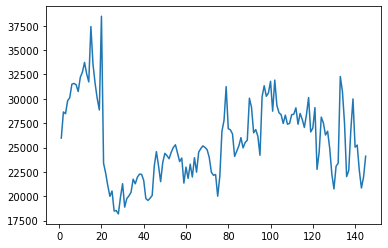

In [19]:
info = get_single_cell_info(cell_dict, 13)
plt.plot(info[0], info[1])
plt.show()
# info = get_single_cell_info(children_dict, 104)
# plt.plot(info[0], info[1])
# plt.show()

In [30]:
get_single_cell_gif_test(cell_dict, 39)